<a href="https://colab.research.google.com/github/namnitha/CE888-Data-Science/blob/master/Project/Assignment2/Google_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import os
import json
from pandas.io.json import json_normalize

In [4]:
import os
os.environ['KAGGLE_USERNAME'] = "namnitha" # username from the json file
os.environ['KAGGLE_KEY'] = "90ceb5b09eaa184f556d4577eb017b49" # key from the json file
!kaggle competitions download -c ga-customer-revenue-prediction # api copied from kaggle

 86% 49.0M/56.8M [00:02<00:00, 19.9MB/s]
100% 56.8M/56.8M [00:02<00:00, 27.4MB/s]
  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 173MB/s]
 93% 57.0M/61.1M [00:01<00:00, 48.2MB/s]
100% 61.1M/61.1M [00:01<00:00, 46.8MB/s]
100% 1.11G/1.11G [00:45<00:00, 25.6MB/s]
100% 1.11G/1.11G [00:45<00:00, 26.4MB/s]
 98% 328M/333M [00:09<00:00, 81.1MB/s]
100% 333M/333M [00:09<00:00, 38.6MB/s]
  0% 0.00/5.23M [00:00<?, ?B/s]
100% 5.23M/5.23M [00:00<00:00, 78.4MB/s]


In [5]:
!ls

sample_data		      test.csv.zip     train_v2.csv.zip
sample_submission.csv.zip     test_v2.csv.zip
sample_submission_v2.csv.zip  train.csv.zip


In [9]:
from zipfile import ZipFile
file_name = "train.csv.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')
file_name = "test.csv.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done
Done


Loading the train and test data



In [0]:
def load_df(csv_path='train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [11]:
print('Loading Train set...')
train = load_df()

Loading Train set...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.


Loaded train.csv. Shape: (903653, 55)


In [12]:
print('Loading Test set...')
test = load_df("test.csv")

Loading Test set...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.


Loaded test.csv. Shape: (804684, 53)


In [13]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

In [14]:
test.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.newVisits,totals.bounces,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.referralPath,trafficSource.adContent
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Southeast Asia,Singapore,(not set),(not set),(not set),not available in demo dataset,myrepublic.com.sg,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,4,NaN,NaN,(not set),google,organic,(not provided),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Aragon,(not set),Zaragoza,not available in demo dataset,rima-tde.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,5,5,1,NaN,(not set),google,organic,(not provided),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Western Europe,France,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,sfr.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,7,7,1,NaN,(not set),google,organic,(not provided),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20171016,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,Safari,not available in demo dataset,not available in demo dataset,iOS,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in dem

Plotting histograms for random columns in comparision with the train vs test colums

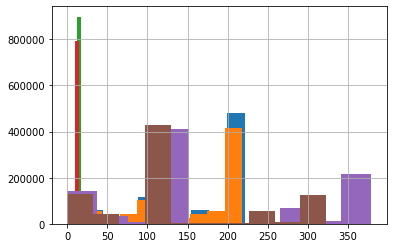

In [31]:
train['geoNetwork.country'].hist() 
test['geoNetwork.country'].hist()
train["trafficSource.adContent"].hist() 
test['trafficSource.adContent'].hist()
train["trafficSource.source"].hist() 
test['trafficSource.source'].hist()

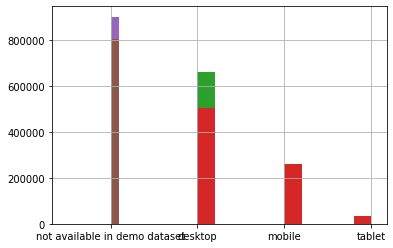

In [16]:
train['device.browserVersion'].hist() 
test['device.browserVersion'].hist()
train["device.deviceCategory"].hist() 
test['device.deviceCategory'].hist()
train["device.flashVersion"].hist() 
test['device.flashVersion'].hist()

In [17]:
print('Imputing missing values...')
for i in train.columns:
    if train[i].dtype == 'object':
      train[i] = train[i].fillna(train[i].mode().iloc[0])
    elif (train[i].dtype != 'object'):
      train[i] = train[i].fillna(np.mean(train[i]))


for i in test.columns:
    if test[i].dtype == 'object':
      test[i] = test[i].fillna(test[i].mode().iloc[0])
    elif (test[i].dtype != 'object'):
      test[i] = test[i].fillna(np.mean(test[i]))
    

print('Nulls in train set:', train.isnull().sum().sum())
print('Nulls in test set:', test.isnull().sum().sum())

Imputing missing values...
Nulls in train set: 0
Nulls in test set: 0


In [18]:
print('Label Encoding categorical variables...')
for col in train.columns:
    if train[col].dtype == 'object':
      train[col] = train[col].astype('category')
      train[col] = train[col].cat.codes

for col in test.columns:
    if test[col].dtype == 'object':
      test[col] = test[col].astype('category')
      test[col] = test[col].cat.codes

Label Encoding categorical variables...


In [0]:
train['set'] = 0
test['set'] = 1
train = train.drop(['totals.transactionRevenue', 'trafficSource.campaignCode'],axis=1)

In [20]:
train_df = train.sample(10000, random_state=697)
test_df = test.sample(10000, random_state=466)

all_data = train_df.append(test_df)
y_label = all_data['set']
all_data = all_data.drop('set',axis=1)

#Making sure that the new dataframe contains all the initial features
print('New dataframe shape:', all_data.shape)

New dataframe shape: (20000, 53)


In [45]:
from sklearn.model_selection import train_test_split
#adding a column to identify whether a row comes from train or not
test['is_train'] = 1
train['is_train'] = 0 
#combining test and train data
df_combine = pd.concat([train, test], axis=0, ignore_index=True)
y = df_combine['is_train'].values #labels
X = df_combine.drop('is_train', axis=1).values #covariates or our independent variables
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25, random_state = 42)
print('set2 train shape:', X_train.shape, 'set2 test shape:', X_test.shape)


set2 train shape: (1281252, 40) set2 test shape: (427085, 40)


In [0]:
clf = RandomForestRegressor(n_estimators = 200, random_state = 42)
clf.fit(X_train, y_train)
probs_y_test = clf.predict(X_test) #calculating the predictions

In [48]:
predictions = clf.predict(X_test)
##Calculating the training accuracy
print('ROC-AUC for train and test distributions:', round(AUC(y_true=y_test, y_score=probs_y_test[:,1]), 4)
print("ROC-AUC score for train and test distributions: ", clf.score(X_train, y_train))

ROC-AUC score for train and test distributions:  1.0


###Interpreting the results
Output of the ROC-AUC metric for our classifier as an estimation of how much covariate shift this data has. and the score implies that it have strong covariate shift

If the classifier is able to classify the rows into train and test with good accuracy, our AUC score should be on the higher side (greater than 0.8). This implies a strong covariate shift between train and test.

In [21]:
model = RandomForestClassifier(n_estimators = 50, max_depth = 5, min_samples_leaf = 5)
feat_to_drop = []
for col in all_data.columns:
    score = cross_val_score(model,pd.DataFrame(all_data[col]),y_label,cv=4,scoring='roc_auc')
    if np.mean(score) > 0.8:
        feat_to_drop.append(col)
    print(col,np.mean(score))

channelGrouping 0.57639872
date 1.0
fullVisitorId 0.57444508
sessionId 0.55900078
socialEngagementType 0.5
visitId 1.0
visitNumber 0.51823682
visitStartTime 1.0
device.browser 0.9993811399999999
device.browserVersion 0.5
device.browserSize 0.5
device.operatingSystem 0.8918289399999999
device.operatingSystemVersion 0.5
device.isMobile 0.55175
device.mobileDeviceBranding 0.5
device.mobileDeviceModel 0.5
device.mobileInputSelector 0.5
device.mobileDeviceInfo 0.5
device.mobileDeviceMarketingName 0.5
device.flashVersion 0.5
device.language 0.5
device.screenColors 0.5
device.screenResolution 0.5
device.deviceCategory 0.55224268
geoNetwork.continent 0.52103394
geoNetwork.subContinent 0.54140232
geoNetwork.country 0.9145905
geoNetwork.region 0.7061219000000001
geoNetwork.metro 0.9416382400000001
geoNetwork.city 0.96046828
geoNetwork.cityId 0.5
geoNetwork.networkDomain 0.795118
geoNetwork.latitude 0.5
geoNetwork.longitude 0.5
geoNetwork.networkLocation 0.5
totals.visits 0.5
totals.hits 0.767824

In [22]:
print('Number of features with covariate shift:', len(feat_to_drop))

Number of features with covariate shift: 14


As we can see, classifier found reasonable difference between train data and test data. As per the considered threshold value, these AUC scores show that there are 14 features contain covariate shift.

As per the AUC score we attained from data, we can say that there is active covariate shift in the dataset.


In [0]:
import seaborn as sns
def histo(test, train, feature):
  print("Histogram of dataset on '",feature,"'")
  histo = sns.distplot(test[[feature]].values.T[0], color="blue", kde=False, label="Testing data")
  histo = sns.distplot(train[[feature]].values.T[0], color="red", kde=False, label="Training data")
  legend = histo.legend()

Histogram of dataset on ' date '


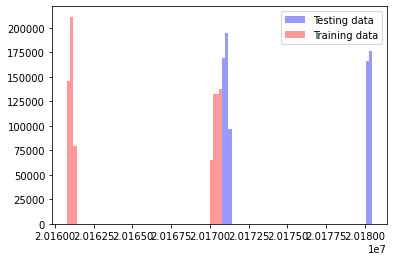

In [32]:
histo(test, train,feat_to_drop[0])

In [56]:
train = train.drop(columns=feat_to_drop)
test = test.drop(columns=feat_to_drop)

clf = RandomForestRegressor(n_estimators=200, max_depth=6,max_features=10)
clf.fit(train.drop('trafficSource.adContent	',axis=1),train['trafficSource.adContent	'])
prob = clf.predict(drift_test)

columns = ['device.browserVersion']
sub = pd.DataFrame(data = probs_y_test ,columns=columns)
sub['geoNetwork.subContinent'] = test['geoNetwork.subContinent']
sub = sub[['geoNetwork.subContinent','device.browserVersion']]
sub.to_csv('without_drifting.csv', index=False)
!kaggle competitions submit -c ga-customer-revenue-prediction -f without_drifting.csv -m "without drifting"

100% 2.80M/2.80M [00:01<00:00, 1.61MB/s]
Successfully submitted to Google Analytics Customer Revenue Prediction

The score was 0.3313 which is good value so without the driffting features of covariate shift.